In [25]:
# Goal: Direct model comparison between arnett, arnett-r0 (tigerfit) and other
import sys, collections, shelve, json, random, multiprocessing
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numba
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import astropy.units as u
import astropy.table as table
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import seaborn
import tqdm
import pandas as pd
# show all columns.. will have scrollbar anyway
pd.options.display.max_columns = None
try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataset as dataset
import snelib19odp.const as const
import snelib19odp.utils as utils
import snelib19odp.tigerfit as tigerfit
import snelib19odp.analysis.arnett as arnett
import snelib19odp.analysis.shock_fit as shock_fit

In [26]:
class DS(collections.namedtuple('DS', 'name texpl_min texpl_max vsc_peak vsc_peak_err')):
    def load(self):
        return dataset.load_dataset(self.name)
    @property
    def texpl_range(self):
        return (self.texpl_min, self.texpl_max)
    @property
    def time_valid(self):
        ds = self.load()
        t_min, _ = ds.get_bolometric('lyman').validity_range
        return np.array([[t_min, ds.transient.prior_t0+50]])
    def show(self):
        print('== Dataset[%s] ==' % self.name)
        print('prior tpeak = %f' % self.load().transient.prior_t0)
        print('texpl in [%.1f, %.1f]' % self.texpl_range)
        print('tvalid in %s' % repr(self.time_valid))
        print('vsc_peak = %f \pm %f km/s\n\n' % (self.vsc_peak, self.vsc_peak_err))

In [27]:
class Result(collections.namedtuple('Result', 'sampler result logz runner')):
    pass

Tag = collections.namedtuple('Tag', 'ds_name model params')

results = shelve.open('2022-10-06-model-comparison-results.shelve')


In [28]:

class Runner(object):
    
    def __init__(self, ds, model, params, pool=None):
        lds = ds.load()
        
        texpl_range = ds.texpl_range
        time_valid = ds.time_valid
        vsc_range = (ds.vsc_peak - ds.vsc_peak_err/2, ds.vsc_peak + ds.vsc_peak_err/2)
        
        tf_prior_kwargs = {
            'vej_min': ds.vsc_peak - ds.vsc_peak_err/2,
            'vej_max': ds.vsc_peak + ds.vsc_peak_err/2,
        }
        
        shock_t_diff_env_range = (0.5, 10)
        shock_r_env_range = (0.1, 100)
        
        time_range = (float(params[0] + time_valid[0][0]), float(params[1]+lds.transient.prior_t0))
        
        if model == 'arnett':
            self.sampler_w = arnett.nested_fitting(lds, time_range=time_range, texpl_range=texpl_range, time_valid=time_valid, sampler='dynamic_nested')
            self.sampler = self.sampler_w.sampler
        elif model == 'arnett_alt':
            self.sampler_w = arnett.nested_fitting_alt(lds, time_range=time_range, vsc_range=vsc_range, texpl_range=texpl_range, time_valid=time_valid, pool=pool)
            self.sampler = self.sampler_w.sampler
        elif model == 'arnett_r0':
            self.sampler_w = arnett.nested_fitting_nico_r0(lds, time_range=time_range, vsc_range=vsc_range, texpl_range=texpl_range, time_valid=time_valid, pool=pool)
            self.sampler = self.sampler_w.sampler
        elif model == 'tigerfit':
            self.sampler = tigerfit.nested_fitting(lds, time_range=time_range, time_valid=time_valid, texpl_range=texpl_range, prior_kwargs=tf_prior_kwargs)
        elif model == 'tigerfit_e_th':
            self.sampler = tigerfit.nested_fitting(lds, time_range=time_range, time_valid=time_valid, texpl_range=texpl_range, include_e_thermal=True, prior_kwargs=tf_prior_kwargs)
        elif model == 'tigerfit_trapped':
            self.sampler = tigerfit.nested_fitting(lds, time_range=time_range, time_valid=time_valid, texpl_range=texpl_range, prior_kwargs=tf_prior_kwargs, gamma_trapped=True)
        elif model == 'piro2020_tdiff':
            texpl_range = (ds.texpl_range[0]-5, ds.texpl_range[1])
            self.sampler_w = shock_fit.nested_fitting_shock_arnett_tdiff(lds, time_range=time_range, vsc_range=vsc_range, texpl_range=texpl_range, time_valid=time_valid, r_env_range=shock_r_env_range, t_diff_env_range=shock_t_diff_env_range, sampler='dynamic_nested')
            self.sampler = self.sampler_w.sampler
        elif model == 'piro2020_me':
            texpl_range = (ds.texpl_range[0]-5, ds.texpl_range[1])
            self.sampler_w = shock_fit.nested_fitting_shock_arnett_me(lds, time_range=time_range, vsc_range=vsc_range, texpl_range=texpl_range, time_valid=time_valid, r_env_range=shock_r_env_range, sampler='dynamic_nested')
            self.sampler = self.sampler_w.sampler
    def run(self):
        self.sampler.run_nested()
        logz = self.sampler.results.logz[-1]
        return Result(sampler=self.sampler, result=self.sampler.results, logz=logz, runner=self)

In [29]:
# Setup all the datasets
# 1/np.sqrt(0.6) is the constant in eqn. 10 (relating scale velocity to mean velocity)
# also known as I_K/I_M in Arnett parlence and ranges from 0.77 to 0.3
sn2019odp = DS('SN2019odp_phot', 58712.48, 58716.38, 10912/np.sqrt(0.6), 1435/np.sqrt(0.6))
sn2019odp.show()
ptf13bvn = DS('iPTF13bvn', 56458.3-0.8, 56458.3+0.8, 8000/np.sqrt(0.6), 1000/np.sqrt(0.6))
ptf13bvn.show()
sn1998bw = DS('SN1998bw', 50928.908, 50928.909, 19500/np.sqrt(0.6), 1700/np.sqrt(0.6))
sn1998bw.show()

== Dataset[SN2019odp_phot] ==
prior tpeak = 58734.000000
texpl in [58712.5, 58716.4]


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


tvalid in array([[58717.3948958, 58784.       ]])
vsc_peak = 14087.331425 \pm 1852.577034 km/s


== Dataset[iPTF13bvn] ==
prior tpeak = 56477.000000
texpl in [56457.5, 56459.1]
tvalid in array([[56460.383, 56527.   ]])
vsc_peak = 10327.955590 \pm 1290.994449 km/s


== Dataset[SN1998bw] ==
prior tpeak = 50945.000000
texpl in [50928.9, 50928.9]
tvalid in array([[50930.63000488, 50995.        ]])
vsc_peak = 25174.391750 \pm 2194.690563 km/s




/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


In [30]:
#tmin_grid = [0, 1, 2, 4, 6]
tmin_grid = [4]
#tmax_grid = [10, 15, 20, 25, 30, 40, 50, 60, 70, 80]
#tmax_grid = [10]
tmax_grid = [25]#20, 25,30]
#models = ['arnett', 'tigerfit', 'tigerfit_e_th', 'tigerfit_trapped']
#models = ['arnett', 'tigerfit', 'tigerfit_trapped']
#models = ['piro2020_me']
#models = ['arnett_alt', 'arnett']
models = ['arnett_r0']
ds_es = [sn2019odp, ptf13bvn, sn1998bw]
#ds_es = [ptf13bvn]

In [31]:
random.shuffle(tmin_grid)
random.shuffle(tmax_grid)
random.shuffle(models)
random.shuffle(ds_es)
for tmax in tmax_grid:
    for tmin in tmin_grid:
        for ds in ds_es:
            for model in models:
                if model in ['arnett', 'tigerfit_trapped', 'arnett_alt'] and tmax > 30:
                    continue
                params = (tmin, tmax)
                tag = Tag(ds.name, model, params=params)
                new_tag = json.dumps([tag.ds_name, tag.model, tag.params])
                if new_tag in results:
                    print('%s already run. Skipping.' % repr(tag))
                    continue
                else:
                    print('Running %s' % repr(tag))
                try:
                    #with multiprocessing.Pool(6) as pool:
                    if True:
                        pool = None
                        run = Runner(ds, model, params=params, pool=pool)
                        result = run.run()
                        results[new_tag] = result
                except np.linalg.LinAlgError:
                    continue

Running Tag(ds_name='iPTF13bvn', model='arnett_r0', params=(4, 25))


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
  0%|          | 0/12000 [00:00<?, ?it/s]/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


Time Range: (56464.383, 56502.0)


100%|██████████| 12000/12000 [00:33<00:00, 363.26it/s]
23631it [06:18, 62.42it/s, +2000 | bound: 68 | nc: 1 | ncall: 277115 | eff(%):  9.249 | loglstar:   -inf < -2.053 <    inf | logz: -15.129 +/-  0.173 | dlogz:  0.002 >  2.009]
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
  0%|          | 15/12000 [00:00<01:22, 145.84it/s]

Running Tag(ds_name='SN1998bw', model='arnett_r0', params=(4, 25))
Time Range: (50934.63000488281, 50970.0)


100%|██████████| 12000/12000 [00:30<00:00, 390.44it/s]
15337it [01:32, 165.61it/s, +2000 | bound: 14 | nc: 1 | ncall: 110932 | eff(%): 15.628 | loglstar:   -inf < -0.266 <    inf | logz: -8.846 +/-  0.102 | dlogz:  0.001 >  2.009]


Running Tag(ds_name='SN2019odp_phot', model='arnett_r0', params=(4, 25))


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
  0%|          | 0/12000 [00:00<?, ?it/s]

Time Range: (58721.3948958, 58759.0)


100%|██████████| 12000/12000 [01:19<00:00, 150.36it/s]
16692it [01:48, 153.85it/s, +2000 | bound: 16 | nc: 1 | ncall: 120002 | eff(%): 15.576 | loglstar:   -inf < -0.110 <    inf | logz: -9.101 +/-  0.106 | dlogz:  0.001 >  2.009]


Loading ['SN2019odp_phot', 'piro2020_tdiff', [0, 30]]
Mni -> 0.22758279082095137 \pm 0.0002624742453530557
Mej -> 5.663112513804959 \pm 1.492178775902888
v_sc -> 14100.286737433218 \pm 262124.35402692686
texpl -> 58714.85605213687 \pm 0.901097758482259
R_e -> -0.02525035090028741 \pm 1.9287218935847619
n -> 13.227929621776399 \pm 16.50486713414032
t_diff -> 4.563543232957235 \pm 7.2283365753163915


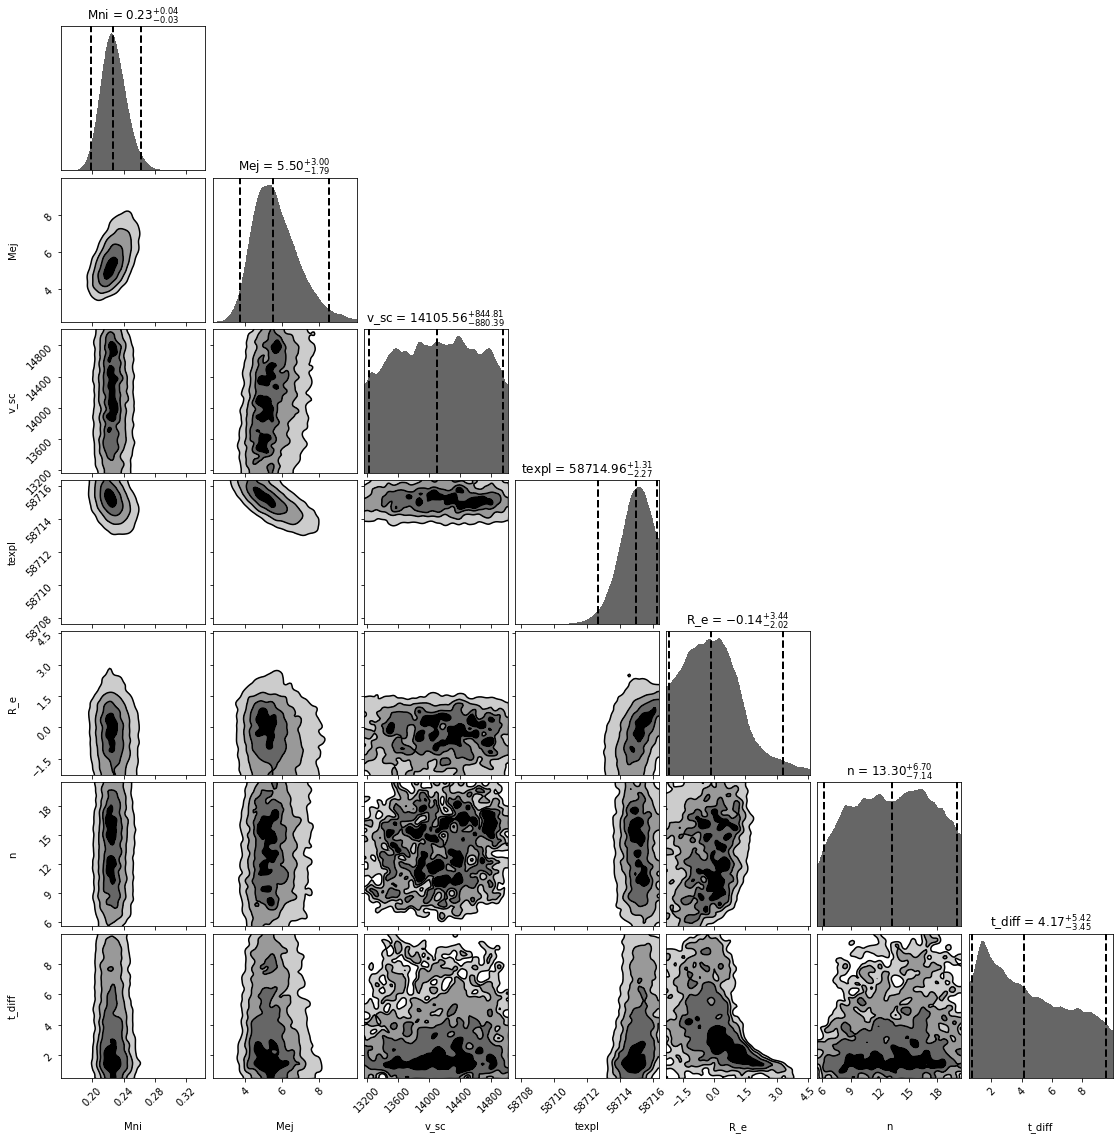

In [18]:
idx = 0
labels = ['Mni', 'Mej', 'v_sc', 'texpl', 'R_e', 'n', 't_diff']
k = list(results.keys())[idx]
tag = json.loads(k)
print(f"Loading {tag}")
r = results[k]
samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)

for i,l in enumerate(labels):
    print(f"{l} -> {mean[i]} \pm {cov[i,i]}")

dyplot.cornerplot(r.result, labels=labels, show_titles=True);

Loading ['SN2019odp_phot', 'piro2020_me', [0, 10]]


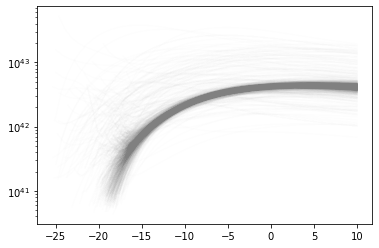

In [17]:
idx = 3
k = list(results.keys())[idx]
tag = json.loads(k)
print(f"Loading {tag}")
r = results[k]
samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)

lum_func = np.vectorize(shock_fit.luminosity_shock_arnett_tdiff)

peak_t = sn2019odp.load().transient.prior_t0

for i in range(1000):
    idx = np.random.randint(0, samples.shape[0])
    p = samples[idx]
    t_grid = np.linspace(p[3]+1, peak_t+10)
    lum = lum_func(t_grid, *p)
    plt.plot(t_grid - peak_t, np.exp(lum), alpha=0.01, color='grey')
plt.yscale('log')

In [10]:
def extract_p20_menv(tag, r):
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    assert tag.model in ['piro2020_tdiff', 'piro2020_me']
    t_diff = samples[:,6]
    vsc = samples[:,2]
    n = samples[:,5]
    
    K = (n-3)*(3-1.1)/4/np.pi/(n-1.1)
    opacity = 0.07 #cm^-2 g
    c_cgs = aconst.c.cgs.value
    return u.g.to(u.Msun) * (t_diff*u.d.to(u.s))**2 * (n-1) * (vsc*u.km.to(u.cm))*c_cgs/3/opacity/K

In [11]:
idx = 2
k = list(results.keys())[idx]
tag = json.loads(k)
rtag = Tag(*tag)
print(f"Loading {tag}")
r = results[k]
samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])

me = extract_p20_menv(rtag, r)
mej = samples[:,1]
#plt.hist(me);
#plt.scatter(mej, me, marker='.', s=0.1)
plt.hist(me/mej);

Loading ['SN2019odp_phot', 'piro2020_me', [0, 30]]


Loading ['SN2019odp_phot', 'piro2020_me', [0, 30]]


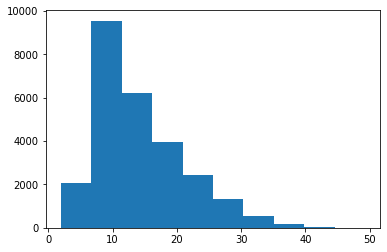

In [23]:
# show t_ph distribution
idx = 2
k = list(results.keys())[idx]
tag = json.loads(k)
rtag = Tag(*tag)
print(f"Loading {tag}")
r = results[k]
samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])

me = extract_p20_menv(rtag, r)
n = samples[:,5]
K = (n-3)*(3-1.1)/4/np.pi/(n-1.1)
vsc = samples[:,2]

opacity = 0.07
t_ph = np.sqrt(3*opacity*K*(me*u.Msun.to(u.g))/2/(n-1)/(vsc*u.km.to(u.cm))**2) * u.s.to(u.d)
plt.hist(t_ph);

Loading ['SN2019odp_phot', 'piro2020_me', [0, 30]]


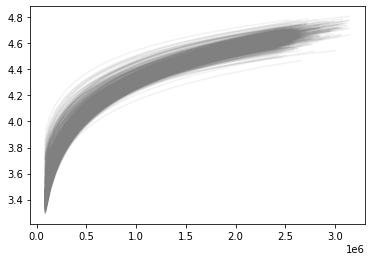

In [32]:
# draw sample r_ph lightcurves
# show t_ph distribution
idx = 2
k = list(results.keys())[idx]
tag = json.loads(k)
rtag = Tag(*tag)
print(f"Loading {tag}")
r = results[k]
samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])

me = extract_p20_menv(rtag, r)
n = samples[:,5]
K = (n-3)*(3-1.1)/4/np.pi/(n-1.1)
vsc = samples[:,2]

opacity = 0.07
t_ph = np.sqrt(3*opacity*K*(me*u.Msun.to(u.g))/2/(n-1)/(vsc*u.km.to(u.cm))**2) #* u.s.to(u.d)

for i in range(1000):
    idx = np.random.randint(0, samples.shape[0])
    p = samples[idx]
    t_grid = np.linspace(1, peak_t-p[3]+10) * u.d.to(u.s)
    
    r_ph = (t_ph[idx]/t_grid)**(2/(n[idx]-1)) * (vsc[idx]*u.km.to(u.cm)) * t_grid
    #r_ph = vsc[idx] * t_grid
    plt.plot(t_grid, np.log10(r_ph*u.cm.to(u.Rsun)), alpha=0.1, color='grey')
#plt.yscale('log')

In [29]:
r_ph

array([7.07560601e+13, 7.07567743e+13, 7.07574886e+13, 7.07582028e+13,
       7.07589171e+13, 7.07596313e+13, 7.07603456e+13, 7.07610598e+13,
       7.07617740e+13, 7.07624883e+13, 7.07632025e+13, 7.07639168e+13,
       7.07646310e+13, 7.07653453e+13, 7.07660595e+13, 7.07667737e+13,
       7.07674880e+13, 7.07682022e+13, 7.07689165e+13, 7.07696307e+13,
       7.07703450e+13, 7.07710592e+13, 7.07717734e+13, 7.07724877e+13,
       7.07732019e+13, 7.07739162e+13, 7.07746304e+13, 7.07753447e+13,
       7.07760589e+13, 7.07767731e+13, 7.07774874e+13, 7.07782016e+13,
       7.07789159e+13, 7.07796301e+13, 7.07803444e+13, 7.07810586e+13,
       7.07817728e+13, 7.07824871e+13, 7.07832013e+13, 7.07839156e+13,
       7.07846298e+13, 7.07853441e+13, 7.07860583e+13, 7.07867725e+13,
       7.07874868e+13, 7.07882010e+13, 7.07889153e+13, 7.07896295e+13,
       7.07903438e+13, 7.07910580e+13])

In [32]:
def extract_mni(tag, r):
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    mean, cov = dyfunc.mean_and_cov(samples, weights)
    trace = dyfunc.resample_equal(samples, weights)
    if tag.model in ['arnett', 'arnett_alt', 'arnett_r0']:
        return (mean[0], cov[0][0], trace[:,0])
    elif tag.model in ['tigerfit', 'tigerfit_e_th', 'tigerfit_trapped']:
        return (mean[0], cov[0][0], trace[:,0])
    else:
        return (np.nan, np.nan, np.array([]))

In [33]:
def get_ds(tag):
    if tag.ds_name == 'SN2019odp_phot':
        return sn2019odp
    elif tag.ds_name == 'iPTF13bvn':
        return ptf13bvn
    elif tag.ds_name == 'SN1998bw':
        return sn1998bw
    else:
        return None

def extract_mej(tag, r):
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    ds = get_ds(tag)
    
    if tag.model == 'arnett':
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        v_sc = np.random.normal(ds.vsc_peak, ds.vsc_peak_err, size=len(td)) * u.km.to(u.cm)
        m_ej = td**2 * beta * c * v_sc / 2 / opacity * u.g.to(u.Msun)
        return np.nanmean(trace[:,1]), np.nanstd(trace[:,1]), np.nanmean(m_ej), np.nanstd(m_ej), m_ej
    elif tag.model == 'arnett_r0':
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        v_sc = trace[:,5]
        m_ej = td**2 * beta * c * v_sc / 2 / opacity * u.g.to(u.Msun)
        return np.nanmean(trace[:,1]), np.nanstd(trace[:,1]), np.nanmean(m_ej), np.nanstd(m_ej), m_ej
    elif tag.model == 'arnett_alt':
        m_ej = trace[:,1]
        return np.nan, np.nan, np.nanmean(m_ej), np.nanstd(m_ej), m_ej
    elif tag.model in ['tigerfit', 'tigerfit_e_th', 'tigerfit_trapped']:
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        #v_sc = np.random.normal(ds.vsc_peak, ds.vsc_peak_err, size=len(td)) * u.km.to(u.cm)
        v_sc = trace[:,3] * u.km.to(u.cm)
        m_ej = td**2 * beta * c * v_sc / 2 / opacity * u.g.to(u.Msun)
        return np.nanmean(trace[:,1]), np.nanstd(trace[:,1]), np.nanmean(m_ej), np.nanstd(m_ej), m_ej
    else:
        return (np.nan, np.nan, np.nan, np.nan, np.array([]))

def extract_ekin(tag, r):
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    ds = get_ds(tag)
    
    if tag.model == 'arnett_alt':
        m_ej = trace[:,1] # [Msol]
        v_sc = trace[:,2] # [km/s]
        # we need * v_m^2 -> * \xi^2 -> * 0.6 = 3/5
        e_kin = m_ej * u.Msun.to(u.g) / 2 * (v_sc * u.km.to(u.cm))**2 * 0.6 / 1e51 # [foe]
    elif tag.model == 'arnett_r0':
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        
        v_sc = trace[:,5] # [cm/s]
        # we need * v_m^2 -> * \xi^2 -> * 0.6 = 3/5
        e_kin = td**2 * beta * c * v_sc**3 * 0.6 / 4 / opacity / 1e51 # [foe]
    elif tag.model == 'arnett':
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        v_sc = np.random.normal(ds.vsc_peak, ds.vsc_peak_err, size=len(td)) * u.km.to(u.cm)
        # we need * v_m^2 -> * \xi^2 -> * 0.6 = 3/5
        e_kin = td**2 * beta * c * v_sc**3 * 0.6 / 4 / opacity / 1e51 # [foe]
    return np.nanmean(e_kin), np.nanstd(e_kin), e_kin
    
def extract_r0(tag, r):
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    ds = get_ds(tag)
    
    if tag.model in ['tigerfit', 'tigerfit_e_th', 'tigerfit_trapped']:
        r0 = trace[:,2] * 1e15 * u.cm.to(u.Rsun)
        rn,rp = np.quantile(r0, [0.16, 0.84])
        mean = np.nanmean(r0)
        return mean, np.nanstd(r0), (mean-rn), (rp-mean)
    elif tag.model == 'arnett_r0':
        r0 = trace[:,3] * u.cm.to(u.Rsun)
        rn,rp = np.quantile(r0, [0.16, 0.84])
        mean = np.nanmean(r0)
        return mean, np.nanstd(r0), (mean-rn), (rp-mean)
    else:
        return np.nan, np.nan, np.nan, np.nan

In [34]:
# extract the data
d = {'tag': [], 'logz': [], 'model': [], 'tmin': [], 'tmax': [], 'duration': [], 'dataset': [], 'Mni': [], 'Mni_err': [], 'Mni_err_neg': [], 'Mni_err_pos': [], 'Mej': [], 'Mej_err': [], 'Mej_err_neg': [], 'Mej_err_pos': [], 'Ek': [], 'Ek_err': [], 'R0': [], 'R0_err': [], 'R0_err_n': [], 'R0_err_p': [], 't_d': [], 't_d_err': []}
for k in results.keys():
    tag = json.loads(k)
    rtag = Tag(*tag)
    # the Piro2021 models here are not really relevant
    if rtag.model in ['piro2020_me', 'piro2020_tdiff']:
        continue
    ds = get_ds(rtag)
    v = results[k]
    d['tag'].append(k)
    d['logz'].append(v.logz)
    #d['tmin'].append(tag[2][0])
    d['tmax'].append(tag[2][1])
    time_range = (float(rtag.params[0] + ds.time_valid[0][0]), float(rtag.params[1]+ds.load().transient.prior_t0))
    d['tmin'].append(rtag.params[0] + ds.time_valid[0][0] - ds.load().transient.prior_t0)
    d['duration'].append(time_range[1] - time_range[0])
    d['dataset'].append(tag[0])
    d['model'].append(tag[1])
    mni, mni_err, mni_trace = extract_mni(rtag, v)
    d['Mni'].append(mni)
    d['Mni_err'].append(mni_err)
    mni_perc = np.percentile(mni_trace, [15.9, 50, 84.1])
    d['Mni_err_neg'].append(mni_perc[1]-mni_perc[0])
    d['Mni_err_pos'].append(mni_perc[2]-mni_perc[1])
    
    ek, ek_err, _ = extract_ekin(rtag, v)
    d['Ek'].append(ek)
    d['Ek_err'].append(ek_err)
    
    td, td_err, mej, mej_err, mej_trace = extract_mej(rtag, v)
    d['Mej'].append(mej)
    d['Mej_err'].append(mej_err)
    mej_perc = np.percentile(mej_trace, [15.9, 50, 84.1])
    d['Mej_err_neg'].append(mej_perc[1]-mej_perc[0])
    d['Mej_err_pos'].append(mej_perc[2]-mej_perc[1])
    
    d['t_d'].append(td)
    d['t_d_err'].append(td_err)
    r0, r0_err, r0_en, r0_ep = extract_r0(rtag, v)
    d['R0'].append(r0)
    d['R0_err'].append(r0_err)
    d['R0_err_n'].append(r0_en)
    d['R0_err_p'].append(r0_ep)
    
#import pandas as pd
df = pd.DataFrame(data=d)
df

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the f

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the f

tag       logz       model  \
0   ["SN2019odp_phot", "arnett_alt", [6, 30]]  -5.859439  arnett_alt   
1       ["SN2019odp_phot", "arnett", [6, 30]]  -6.866713      arnett   
2        ["iPTF13bvn", "arnett_alt", [6, 30]] -14.579292  arnett_alt   
3        ["iPTF13bvn", "arnett_alt", [2, 25]] -12.319349  arnett_alt   
4   ["SN2019odp_phot", "arnett_alt", [2, 25]]  -6.045588  arnett_alt   
5        ["iPTF13bvn", "arnett_alt", [4, 25]] -12.524474  arnett_alt   
6   ["SN2019odp_phot", "arnett_alt", [4, 25]]  -5.733922  arnett_alt   
7        ["iPTF13bvn", "arnett_alt", [6, 25]] -12.658122  arnett_alt   
8   ["SN2019odp_phot", "arnett_alt", [6, 25]]  -5.656537  arnett_alt   
9        ["iPTF13bvn", "arnett_alt", [2, 30]] -14.180148  arnett_alt   
10  ["SN2019odp_phot", "arnett_alt", [2, 30]]  -6.314376  arnett_alt   
11       ["iPTF13bvn", "arnett_alt", [4, 30]] -14.368524  arnett_alt   
12  ["SN2019odp_phot", "arnett_alt", [4, 30]]  -6.125697  arnett_alt   
13       ["iPTF13bvn", "arnett_alt", [2, 20]] -10.600369  arnett_alt   
14  ["SN2019odp_phot", "arnett_alt", [2, 20]]  -5.995193  arnett_alt   
15       ["iPTF13bvn", "arnett_alt", [4, 20]] -10.415219  arnett_alt   
16  ["SN2019odp_phot", "arnett_alt", [4, 20]]  -5.794400  arnett_alt   
17       ["iPTF13bvn", "arnett_alt", [6, 20]] -10.481060  arnett_alt   
18  ["SN2019odp_phot", "arnett_alt", [6, 20]]  -5.480339  arnett_alt   
19        ["SN1998bw", "arnett_alt", [6, 25]]  -5.400849  arnett_alt   
20            ["SN1998bw", "arnett", [4, 20]]  -5.976182      arnett   
21      ["SN2019odp_phot", "arnett", [8, 10]]  -5.624672      arnett   
22  ["SN2019odp_phot", "arnett_alt", [8, 10]]  -4.633587  arnett_alt   
23           ["iPTF13bvn", "arnett", [8, 10]]  -7.707953      arnett   
24       ["iPTF13bvn", "arnett_alt", [8, 10]]  -7.147515  arnett_alt   
25            ["SN1998bw", "arnett", [8, 10]]  -4.994715      arnett   
26        ["SN1998bw", "arnett_alt", [8, 10]]  -3.462355  arnett_alt   
27        ["iPTF13bvn", "arnett_r0", [4, 25]] -15.128519   arnett_r0   
28         ["SN1998bw", "arnett_r0", [4, 25]]  -8.846240   arnett_r0   
29   ["SN2019odp_phot", "arnett_r0", [4, 25]]  -9.100709   arnett_r0   

         tmin  tmax   duration         dataset       Mni   Mni_err  \
0  -10.605104    30  40.605104  SN2019odp_phot  0.240527  0.002312   
1  -10.605104    30  40.605104  SN2019odp_phot  0.237659  0.002101   
2  -10.617000    30  40.617000       iPTF13bvn  0.067886  0.000259   
3  -14.617000    25  39.617000       iPTF13bvn  0.072402  0.000273   
4  -14.605104    25  39.605104  SN2019odp_phot  0.245441  0.002394   
5  -12.617000    25  37.617000       iPTF13bvn  0.071545  0.000249   
6  -12.605104    25  37.605104  SN2019odp_phot  0.246551  0.002363   
7  -10.617000    25  35.617000       iPTF13bvn  0.071822  0.000254   
8  -10.605104    25  35.605104  SN2019odp_phot  0.246232  0.002380   
9  -14.617000    30  44.617000       iPTF13bvn  0.068059  0.000251   
10 -14.605104    30  44.605104  SN2019odp_phot  0.238494  0.002194   
11 -12.617000    30  42.617000       iPTF13bvn  0.067391  0.000229   
12 -12.605104    30  42.605104  SN2019odp_phot  0.239433  0.002225   
13 -14.617000    20  34.617000       iPTF13bvn  0.076416  0.000302   
14 -14.605104    20  34.605104  SN2019odp_phot  0.253198  0.002710   
15 -12.617000    20  32.617000       iPTF13bvn  0.076122  0.000312   
16 -12.605104    20  32.605104  SN2019odp_phot  0.253750  0.002634   
17 -10.617000    20  30.617000       iPTF13bvn  0.077639  0.000363   
18 -10.605104    20  30.605104  SN2019odp_phot  0.254154  0.002603   
19  -8.369995    25  33.369995        SN1998bw  0.751857  0.016088   
20 -10.369995    20  30.369995        SN1998bw  0.783452  0.017125   
21  -8.605104    10  18.605104  SN2019odp_phot  0.307362  0.011138   
22  -8.605104    10  18.605104  SN2019odp_phot  0.282076  0.004194   
23  -8.617000    10  18.617000       iPTF13bvn  0.087186  0.000422   
24  -8.617000    10  18.617000       iPTF13bvn  0.089046  0

In [35]:
df.query('dataset == "SN1998bw"')

tag      logz       model       tmin  \
19  ["SN1998bw", "arnett_alt", [6, 25]] -5.400849  arnett_alt  -8.369995   
20      ["SN1998bw", "arnett", [4, 20]] -5.976182      arnett -10.369995   
25      ["SN1998bw", "arnett", [8, 10]] -4.994715      arnett  -6.369995   
26  ["SN1998bw", "arnett_alt", [8, 10]] -3.462355  arnett_alt  -6.369995   
28   ["SN1998bw", "arnett_r0", [4, 25]] -8.846240   arnett_r0 -10.369995   

    tmax   duration   dataset       Mni   Mni_err  Mni_err_neg  Mni_err_pos  \
19    25  33.369995  SN1998bw  0.751857  0.016088     0.115574     0.139275   
20    20  30.369995  SN1998bw  0.783452  0.017125     0.120599     0.136385   
25    10  16.369995  SN1998bw  0.860288  0.027535     0.144466     0.183633   
26    10  16.369995  SN1998bw  0.857015  0.024548     0.140335     0.173705   
28    25  35.369995  SN1998bw  0.748398  0.014449     0.114823     0.119993   

         Mej   Mej_err  Mej_err_neg  Mej_err_pos            Ek        Ek_err  \
19  5.261041  0.999605     0.955965     1.025894  1.991016e+01  4.050851e+00   
20  5.692788  1.074249     0.968027     1.112727  2.198249e+01  6.839950e+00   
25  6.652536  1.878201     1.426995     2.003538  2.574637e+01  9.822123e+00   
26  6.614657  1.424951     1.436369     1.606572  2.508102e+01  5.641791e+00   
28  0.000053  0.000009     0.000008     0.000009  2.013261e-14  3.634717e-15   

          R0    R0_err  R0_err_n  R0_err_p        t_d   t_d_err  
19       NaN       NaN       NaN       NaN        NaN       NaN  
20       NaN       NaN       NaN       NaN  14.227565  1.177437  
25       NaN       NaN       NaN       NaN  15.309630  1.989960  
26       NaN       NaN       NaN       NaN        NaN       NaN  
28  0.001229  0.001543  0.001125  0.001485  13.742403  1.131908

In [36]:
df.query('dataset == "SN2019odp_phot" and model == "arnett"')

tag      logz   model       tmin  tmax  \
1   ["SN2019odp_phot", "arnett", [6, 30]] -6.866713  arnett -10.605104    30   
21  ["SN2019odp_phot", "arnett", [8, 10]] -5.624672  arnett  -8.605104    10   

     duration         dataset       Mni   Mni_err  Mni_err_neg  Mni_err_pos  \
1   40.605104  SN2019odp_phot  0.237659  0.002101     0.042509     0.049288   
21  18.605104  SN2019odp_phot  0.307362  0.011138     0.063730     0.093505   

         Mej   Mej_err  Mej_err_neg  Mej_err_pos         Ek    Ek_err  R0  \
1   5.242579  1.313686     1.125735     1.436997   6.499118  2.896587 NaN   
21  8.186653  4.442876     2.157909     3.717931  10.125249  6.729692 NaN   

    R0_err  R0_err_n  R0_err_p        t_d   t_d_err  
1      NaN       NaN       NaN  18.214022  1.907982  
21     NaN       NaN       NaN  22.337876  4.940025

In [37]:
df.iloc[df.query('tmax > 15').groupby(['dataset', 'model'])['logz'].idxmax()]

tag       logz       model  \
20            ["SN1998bw", "arnett", [4, 20]]  -5.976182      arnett   
19        ["SN1998bw", "arnett_alt", [6, 25]]  -5.400849  arnett_alt   
28         ["SN1998bw", "arnett_r0", [4, 25]]  -8.846240   arnett_r0   
1       ["SN2019odp_phot", "arnett", [6, 30]]  -6.866713      arnett   
18  ["SN2019odp_phot", "arnett_alt", [6, 20]]  -5.480339  arnett_alt   
29   ["SN2019odp_phot", "arnett_r0", [4, 25]]  -9.100709   arnett_r0   
15       ["iPTF13bvn", "arnett_alt", [4, 20]] -10.415219  arnett_alt   
27        ["iPTF13bvn", "arnett_r0", [4, 25]] -15.128519   arnett_r0   

         tmin  tmax   duration         dataset       Mni   Mni_err  \
20 -10.369995    20  30.369995        SN1998bw  0.783452  0.017125   
19  -8.369995    25  33.369995        SN1998bw  0.751857  0.016088   
28 -10.369995    25  35.369995        SN1998bw  0.748398  0.014449   
1  -10.605104    30  40.605104  SN2019odp_phot  0.237659  0.002101   
18 -10.605104    20  30.605104  SN2019odp_phot  0.254154  0.002603   
29 -12.605104    25  37.605104  SN2019odp_phot  0.244729  0.002078   
15 -12.617000    20  32.617000       iPTF13bvn  0.076122  0.000312   
27 -12.617000    25  37.617000       iPTF13bvn  0.071186  0.000256   

    Mni_err_neg  Mni_err_pos       Mej   Mej_err  Mej_err_neg  Mej_err_pos  \
20     0.120599     0.136385  5.692788  1.074249     0.968027     1.112727   
19     0.115574     0.139275  5.261041  0.999605     0.955965     1.025894   
28     0.114823     0.119993  0.000053  0.000009     0.000008     0.000009   
1      0.042509     0.049288  5.242579  1.313686     1.125735     1.436997   
18     0.046323     0.053946  6.006374  1.329438     1.196775     1.526425   
29     0.042568     0.047379  0.000056  0.000012     0.000011     0.000014   
15     0.015588     0.020152  1.947307  0.351315     0.325061     0.367457   
27     0.014616     0.017292  0.000018  0.000003     0.000003     0.000003   

              Ek        Ek_err        R0    R0_err  R0_err_n  R0_err_p  \
20  2.198249e+01  6.839950e+00       NaN       NaN       NaN       NaN   
19  1.991016e+01  4.050851e+00       NaN       NaN       NaN       NaN   
28  2.013261e-14  3.634717e-15  0.001229  0.001543  0.001125  0.001485   
1   6.499118e+00  2.896587e+00       NaN       NaN       NaN       NaN   
18  7.158526e+00  1.753402e+00       NaN       NaN       NaN       NaN   
29  6.690037e-15  1.619637e-15  0.001226  0.001523  0.001115  0.001462   
15  1.248107e+00  2.582996e-01       NaN       NaN       NaN       NaN   
27  1.132375e-15  2.294248e-16  0.001279  0.001568  0.001166  0.001506   

          t_d   t_d_err  
20  14.227565  1.177437  
19        NaN       NaN  
28  13.742403  1.131908  
1   18.214022  1.907982  
18        NaN       NaN  
29  18.889719  2.034979  
15        NaN       NaN  
27  12.380996  1.068853

In [38]:
df.iloc[df.groupby(['dataset', 'model', 'tmin', 'tmax'])['logz'].idxmax()]

tag       logz       model  \
20            ["SN1998bw", "arnett", [4, 20]]  -5.976182      arnett   
25            ["SN1998bw", "arnett", [8, 10]]  -4.994715      arnett   
19        ["SN1998bw", "arnett_alt", [6, 25]]  -5.400849  arnett_alt   
26        ["SN1998bw", "arnett_alt", [8, 10]]  -3.462355  arnett_alt   
28         ["SN1998bw", "arnett_r0", [4, 25]]  -8.846240   arnett_r0   
1       ["SN2019odp_phot", "arnett", [6, 30]]  -6.866713      arnett   
21      ["SN2019odp_phot", "arnett", [8, 10]]  -5.624672      arnett   
14  ["SN2019odp_phot", "arnett_alt", [2, 20]]  -5.995193  arnett_alt   
4   ["SN2019odp_phot", "arnett_alt", [2, 25]]  -6.045588  arnett_alt   
10  ["SN2019odp_phot", "arnett_alt", [2, 30]]  -6.314376  arnett_alt   
16  ["SN2019odp_phot", "arnett_alt", [4, 20]]  -5.794400  arnett_alt   
6   ["SN2019odp_phot", "arnett_alt", [4, 25]]  -5.733922  arnett_alt   
12  ["SN2019odp_phot", "arnett_alt", [4, 30]]  -6.125697  arnett_alt   
18  ["SN2019odp_phot", "arnett_alt", [6, 20]]  -5.480339  arnett_alt   
8   ["SN2019odp_phot", "arnett_alt", [6, 25]]  -5.656537  arnett_alt   
0   ["SN2019odp_phot", "arnett_alt", [6, 30]]  -5.859439  arnett_alt   
22  ["SN2019odp_phot", "arnett_alt", [8, 10]]  -4.633587  arnett_alt   
29   ["SN2019odp_phot", "arnett_r0", [4, 25]]  -9.100709   arnett_r0   
23           ["iPTF13bvn", "arnett", [8, 10]]  -7.707953      arnett   
13       ["iPTF13bvn", "arnett_alt", [2, 20]] -10.600369  arnett_alt   
3        ["iPTF13bvn", "arnett_alt", [2, 25]] -12.319349  arnett_alt   
9        ["iPTF13bvn", "arnett_alt", [2, 30]] -14.180148  arnett_alt   
15       ["iPTF13bvn", "arnett_alt", [4, 20]] -10.415219  arnett_alt   
5        ["iPTF13bvn", "arnett_alt", [4, 25]] -12.524474  arnett_alt   
11       ["iPTF13bvn", "arnett_alt", [4, 30]] -14.368524  arnett_alt   
17       ["iPTF13bvn", "arnett_alt", [6, 20]] -10.481060  arnett_alt   
7        ["iPTF13bvn", "arnett_alt", [6, 25]] -12.658122  arnett_alt   
2        ["iPTF13bvn", "arnett_alt", [6, 30]] -14.579292  arnett_alt   
24       ["iPTF13bvn", "arnett_alt", [8, 10]]  -7.147515  arnett_alt   
27        ["iPTF13bvn", "arnett_r0", [4, 25]] -15.128519   arnett_r0   

         tmin  tmax   duration         dataset       Mni   Mni_err  \
20 -10.369995    20  30.369995        SN1998bw  0.783452  0.017125   
25  -6.369995    10  16.369995        SN1998bw  0.860288  0.027535   
19  -8.369995    25  33.369995        SN1998bw  0.751857  0.016088   
26  -6.369995    10  16.369995        SN1998bw  0.857015  0.024548   
28 -10.369995    25  35.369995        SN1998bw  0.748398  0.014449   
1  -10.605104    30  40.605104  SN2019odp_phot  0.237659  0.002101   
21  -8.605104    10  18.605104  SN2019odp_phot  0.307362  0.011138   
14 -14.605104    20  34.605104  SN2019odp_phot  0.253198  0.002710   
4  -14.605104    25  39.605104  SN2019odp_phot  0.245441  0.002394   
10 -14.605104    30  44.605104  SN2019odp_phot  0.238494  0.002194   
16 -12.605104    20  32.605104  SN2019odp_phot  0.253750  0.002634   
6  -12.605104    25  37.605104  SN2019odp_phot  0.246551  0.002363   
12 -12.605104    30  42.605104  SN2019odp_phot  0.239433  0.002225   
18 -10.605104    20  30.605104  SN2019odp_phot  0.254154  0.002603   
8  -10.605104    25  35.605104  SN2019odp_phot  0.246232  0.002380   
0  -10.605104    30  40.605104  SN2019odp_phot  0.240527  0.002312   
22  -8.605104    10  18.605104  SN2019odp_phot  0.282076  0.004194   
29 -12.605104    25  37.605104  SN2019odp_phot  0.244729  0.002078   
23  -8.617000    10  18.617000       iPTF13bvn  0.087186  0.000422   
13 -14.617000    20  34.617000       iPTF13bvn  0.076416  0.000302   
3  -14.617000    25  39.617000       iPTF13bvn  0.072402  0.000273   
9  -14.617000    30  44.617000       iPTF13bvn  0.068059  0.000251   
15 -12.617000    20  32.617000       iPTF13bvn  0.076122  0.000312   
5  -12.617000    25  37.617000       iPTF13bvn  0.071545  0.000249   
11 -12.617000    30  42.617000       iPTF13bvn  0.067391  0

In [21]:
plt.figure(figsize=(11,11))
df.query('dataset == "SN2019odp_phot" and model == "arnett_alt"').set_index('tmax').sort_index().groupby(['model', 'tmin'])['Mej'].plot(legend=True);

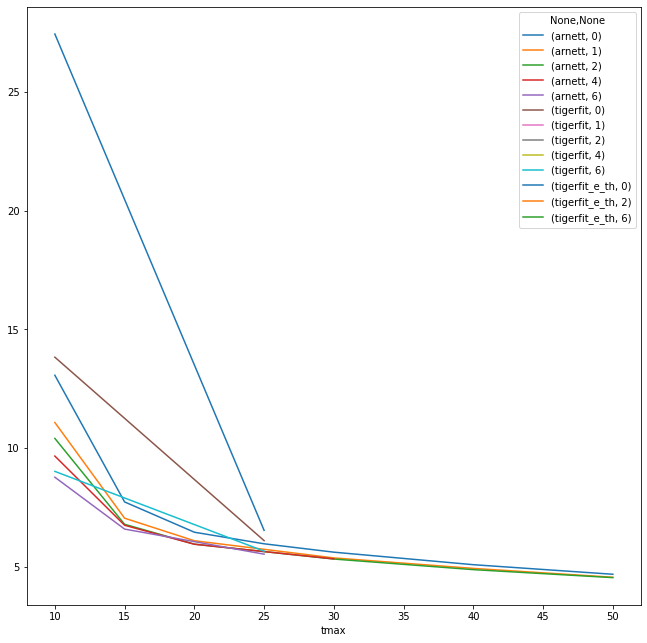

In [84]:
plt.figure(figsize=(11,11))
df.query('dataset == "SN2019odp_phot"').set_index('tmax').sort_index().groupby(['model', 'tmin'])['Mej'].plot(legend=True);

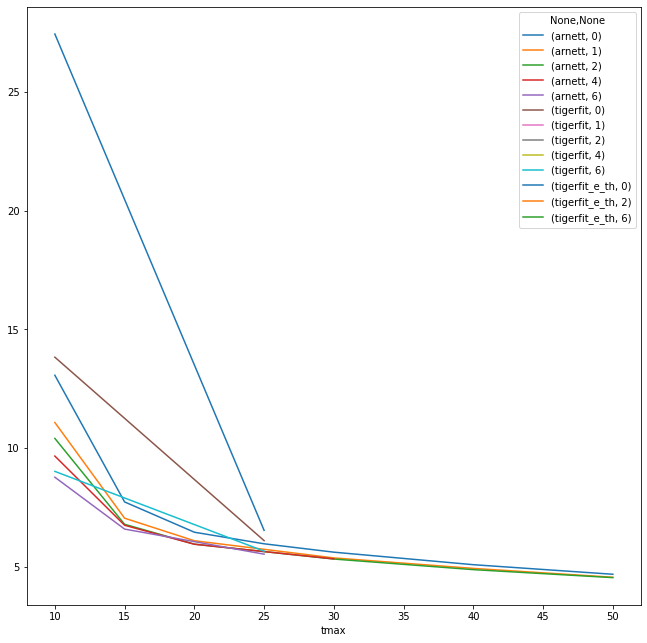

In [76]:
plt.figure(figsize=(11,11))
df.query('dataset == "SN2019odp_phot"').set_index('tmax').sort_index().groupby(['model', 'tmin'])['Mej'].plot(legend=True);

In [77]:
# attempt model averaging
samples_m, weights_m = [], []
for tag in df.query('dataset == "SN2019odp_phot" and model == "arnett"')['tag']:
    tag = json.loads(tag)
    rtag = Tag(*tag)
    r = results[k]
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    samples_m.append(trace)
    weights_m.append(np.ones(len(trace))*np.exp(r.sampler.results.logz[-1]))

In [78]:
samples = np.concatenate(samples_m)
weights = np.concatenate(weights_m)
trace = dyfunc.resample_equal(samples, weights)


/home/welterde/.local/lib/python3.8/site-packages/dynesty/utils.py:163: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


13.820496113839328 1.6037335220324453


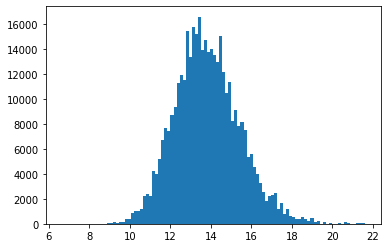

In [79]:
plt.hist(trace[:,1], bins=100)
print(np.nanmean(trace[:,1]), np.nanstd(trace[:,1]))

In [80]:
plt.hist(trace[:,0], bins=100);
print(np.nanmean(trace[:,0]), np.nanstd(trace[:,0]))

0.08177090205238487 0.023063759962569694


3.025368111812644 0.7116823390239713


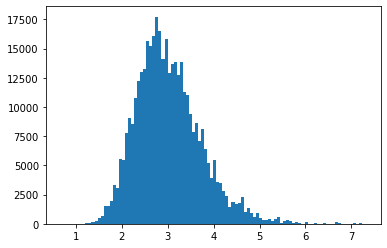

In [81]:
td = trace[:,1] * u.day.to(u.s)
opacity = 0.07
beta = 13.8
c=2.99792458e10
v_sc = sn2019odp.vsc_peak * u.km.to(u.cm)
m_ej = td**2 * beta * c * v_sc / 2 / opacity * u.g.to(u.Msun)
print(np.mean(m_ej), np.std(m_ej))
plt.hist(m_ej, bins=100);

In [82]:
sn2019odp.vsc_peak

14087.33142460511

In [66]:
# delete the tigerfit ones
for k in results:
    if 'tigerfit' in k:
        print(k)
        #del results[k]

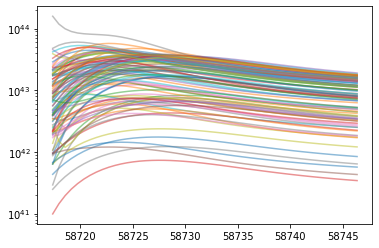

In [7]:
ds = sn2019odp
vsc_min, vsc_max = (ds.vsc_peak - ds.vsc_peak_err/2, ds.vsc_peak + ds.vsc_peak_err/2)
texpl_min, texpl_max = ds.texpl_range

for i in range(100):
    p = shock_fit.prior_shock_arnett_tdiff(np.random.uniform(0, 1, size=7), vsc_min, vsc_max, texpl_min, texpl_max, 0.1, 100, 0.5, 10)
    lum = np.vectorize(shock_fit.luminosity_shock_arnett_tdiff)
    t_grid = np.linspace(sn2019odp.texpl_max+1, sn2019odp.texpl_max+30)
    lums = lum(t_grid, *p)
    plt.plot(t_grid, np.exp(lums), alpha=0.5)
plt.yscale('log')

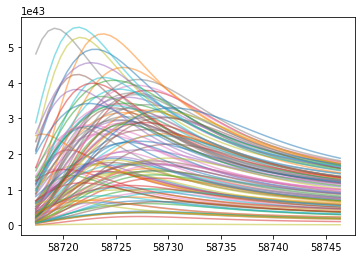

In [21]:
ds = sn2019odp
vsc_min, vsc_max = (ds.vsc_peak - ds.vsc_peak_err/2, ds.vsc_peak + ds.vsc_peak_err/2)
texpl_min, texpl_max = ds.texpl_range

for i in range(100):
    p = arnett.prior_nico_alt(np.random.uniform(0, 1, size=4), vsc_min, vsc_max, texpl_min, texpl_max)
    lum = np.vectorize(arnett.luminosity_nico_alt)
    t_grid = np.linspace(sn2019odp.texpl_max+1, sn2019odp.texpl_max+30)
    lums = lum(t_grid, *p)
    plt.plot(t_grid, np.exp(lums), alpha=0.5)
#plt.yscale('log')

In [43]:
def quantiles2(t):
    q = np.percentile(t, [15.6, 50, 84.1])
    err_neg = q[1] - q[0]
    err_pos = q[2] - q[1]
    return "%.2f_{-%.2f}^{+%.2f}" % (q[1], err_neg, err_pos)

# extract the data
d = {'tag': [], 'logz': [], 'model': [], 'tmin': [], 'tmax': [], 'duration': [], 'dataset': [], 'Mni': [],  'Mej': [], 'Ek': []}
for k in results.keys():
    tag = json.loads(k)
    rtag = Tag(*tag)
    # the Piro2021 models here are not really relevant
    if rtag.model in ['piro2020_me', 'piro2020_tdiff']:
        continue
    ds = get_ds(rtag)
    v = results[k]
    d['tag'].append(k)
    d['logz'].append(v.logz)
    #d['tmin'].append(tag[2][0])
    d['tmax'].append(tag[2][1])
    time_range = (float(rtag.params[0] + ds.time_valid[0][0]), float(rtag.params[1]+ds.load().transient.prior_t0))
    d['tmin'].append(rtag.params[0] + ds.time_valid[0][0] - ds.load().transient.prior_t0)
    d['duration'].append(time_range[1] - time_range[0])
    d['dataset'].append(tag[0])
    d['model'].append(tag[1])
    _mni, _mni_err, mni = extract_mni(rtag, v)
    mni = quantiles2(mni)
    d['Mni'].append(mni)
    
    
    _ek, _ek_err, ek = extract_ekin(rtag, v)
    ek = quantiles2(ek)
    d['Ek'].append(ek)
    
    
    _td, _td_err, _mej, _mej_err, mej = extract_mej(rtag, v)
    mej = quantiles2(mej)
    d['Mej'].append(mej)
    
    
import pandas as pd
df_str = pd.DataFrame(data=d)
df_str

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the f

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the f

tag       logz       model  \
0   ["SN2019odp_phot", "arnett_alt", [6, 30]]  -5.959892  arnett_alt   
1       ["SN2019odp_phot", "arnett", [6, 30]]  -6.866713      arnett   
2        ["iPTF13bvn", "arnett_alt", [6, 30]] -14.579292  arnett_alt   
3        ["iPTF13bvn", "arnett_alt", [2, 25]] -12.319349  arnett_alt   
4   ["SN2019odp_phot", "arnett_alt", [2, 25]]  -6.045588  arnett_alt   
5        ["iPTF13bvn", "arnett_alt", [4, 25]] -12.524474  arnett_alt   
6   ["SN2019odp_phot", "arnett_alt", [4, 25]]  -5.733922  arnett_alt   
7        ["iPTF13bvn", "arnett_alt", [6, 25]] -12.658122  arnett_alt   
8   ["SN2019odp_phot", "arnett_alt", [6, 25]]  -5.656537  arnett_alt   
9        ["iPTF13bvn", "arnett_alt", [2, 30]] -14.180148  arnett_alt   
10  ["SN2019odp_phot", "arnett_alt", [2, 30]]  -6.314376  arnett_alt   
11       ["iPTF13bvn", "arnett_alt", [4, 30]] -14.368524  arnett_alt   
12  ["SN2019odp_phot", "arnett_alt", [4, 30]]  -6.125697  arnett_alt   
13       ["iPTF13bvn", "arnett_alt", [2, 20]] -10.600369  arnett_alt   
14  ["SN2019odp_phot", "arnett_alt", [2, 20]]  -5.995193  arnett_alt   
15       ["iPTF13bvn", "arnett_alt", [4, 20]] -10.415219  arnett_alt   
16  ["SN2019odp_phot", "arnett_alt", [4, 20]]  -5.794400  arnett_alt   
17       ["iPTF13bvn", "arnett_alt", [6, 20]] -10.481060  arnett_alt   
18  ["SN2019odp_phot", "arnett_alt", [6, 20]]  -5.480339  arnett_alt   
19        ["SN1998bw", "arnett_alt", [6, 25]]  -5.400849  arnett_alt   

         tmin  tmax   duration         dataset                   Mni  \
0  -10.605104    30  40.605104  SN2019odp_phot  0.24_{-0.04}^{+0.05}   
1  -10.605104    30  40.605104  SN2019odp_phot  0.23_{-0.04}^{+0.05}   
2  -10.617000    30  40.617000       iPTF13bvn  0.07_{-0.01}^{+0.02}   
3  -14.617000    25  39.617000       iPTF13bvn  0.07_{-0.02}^{+0.02}   
4  -14.605104    25  39.605104  SN2019odp_phot  0.24_{-0.05}^{+0.05}   
5  -12.617000    25  37.617000       iPTF13bvn  0.07_{-0.01}^{+0.02}   
6  -12.605104    25  37.605104  SN2019odp_phot  0.24_{-0.04}^{+0.05}   
7  -10.617000    25  35.617000       iPTF13bvn  0.07_{-0.01}^{+0.02}   
8  -10.605104    25  35.605104  SN2019odp_phot  0.24_{-0.04}^{+0.05}   
9  -14.617000    30  44.617000       iPTF13bvn  0.07_{-0.01}^{+0.02}   
10 -14.605104    30  44.605104  SN2019odp_phot  0.23_{-0.04}^{+0.05}   
11 -12.617000    30  42.617000       iPTF13bvn  0.07_{-0.01}^{+0.02}   
12 -12.605104    30  42.605104  SN2019odp_phot  0.24_{-0.04}^{+0.05}   
13 -14.617000    20  34.617000       iPTF13bvn  0.08_{-0.02}^{+0.02}   
14 -14.605104    20  34.605104  SN2019odp_phot  0.25_{-0.05}^{+0.05}   
15 -12.617000    20  32.617000       iPTF13bvn  0.07_{-0.02}^{+0.02}   
16 -12.605104    20  32.605104  SN2019odp_phot  0.25_{-0.05}^{+0.05}   
17 -10.617000    20  30.617000       iPTF13bvn  0.08_{-0.02}^{+0.02}   
18 -10.605104    20  30.605104  SN2019odp_phot  0.25_{-0.05}^{+0.05}   
19  -8.369995    25  33.369995        SN1998bw  0.74_{-0.12}^{+0.14}   

                     Mej                     Ek  
0   5.28_{-1.01}^{+1.25}   6.27_{-1.32}^{+1.63}  
1   5.12_{-1.15}^{+1.40}   6.04_{-2.28}^{+3.23}  
2   1.62_{-0.34}^{+0.36}   1.03_{-0.23}^{+0.26}  
3   1.76_{-0.29}^{+0.36}   1.12_{-0.21}^{+0.27}  
4   5.53_{-1.09}^{+1.51}   6.58_{-1.45}^{+1.96}  
5   1.77_{-0.31}^{+0.36}   1.12_{-0.22}^{+0.27}  
6   5.52_{-1.08}^{+1.44}   6.60_{-1.50}^{+1.84}  
7   1.73_{-0.32}^{+0.36}   1.10_{-0.22}^{+0.26}  
8   5.51_{-1.05}^{+1.34}   6.51_{-1.42}^{+1.85}  
9   1.65_{-0.30}^{+0.33}   1.05_{-0.21}^{+0.25}  
10  5.33_{-1.00}^{+1.32}   6.32_{-1.37}^{+1.69}  
11  1.65_{-0.30}^{+0.33}   1.06_{-0.22}^{+0.24}  
12  5.37_{-1.00}^{+1.28}   6.38_{-1.31}^{+1.74}  
13  1.90_{-0.31}^{+0.37}   1.21_{-0.23}^{+0.26}  
14  5.83_{-1.15}^{+1.71}   6.96_{-1.54}^{+2.15}  
15  1.92_{-0.33}^{+0.37}   1.23_{-0.24}^{+0.28}  
16  5.94_{-1.24}^{+1.63}   7.02_{-1.60}^{+2.11}  
17  1.87_{-0.33}^{+0.40}   1.20_{-0.25}^{+0.29}  
18  5.88_{-1.21}^{+1.52}   6.99_{-1.57}^{+1.89}  
19  5.22_{-0.97}